Packages needed.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import pulp
from scipy import stats 

Read data

In [3]:
data = pd.read_csv('Advertising1.csv',index_col=0)
data

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9
...,...,...,...,...
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5


In [4]:
data.shape

(200, 4)

<AxesSubplot:>

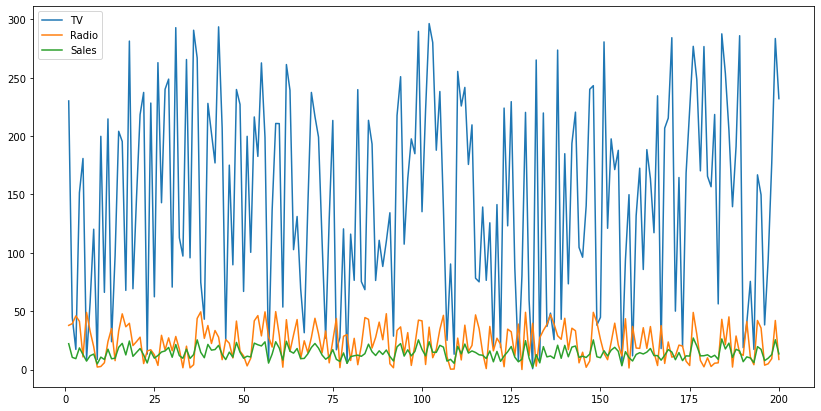

In [4]:
data[['TV',	'Radio', 'Sales']].plot(figsize=(14,7))

## 7.1.1 Deterministic Linear Programming

### Descriptive Analytics:

1. Split data into training and validation set(50-50). 

In [5]:
# first 100 data points for training and remaining 100 data points for validation
train_set = data.iloc[:100,:]
validation_set = data.iloc[100:,:]

2. On the training set, use TV and radio as regressors to obtain the linear regression coefficients.

In [6]:
X_train = train_set[['TV','Radio']].values
y_train = train_set['Sales'].values

X_train = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     487.4
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           2.51e-51
Time:                        09:40:20   Log-Likelihood:                -184.92
No. Observations:                 100   AIC:                             375.8
Df Residuals:                      97   BIC:                             383.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1470      0.398      7.900      0.000       2.356       3.938
x1             0.0459      0.002     24.395      0.000       0.042       0.050
x2             0.1841      0.011     16.918      0.000       0.163       0.206
==============================================================================
Omnibus:                       20.066   Durbin-Watson:                   2.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.744
Skew:                          -1.082   Prob(JB):                     4.24e-06
Kurtosis:                       4.122   Cond. No.                         436.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

3. Calculate εti and εvi by equation (5) and (7).

In [7]:
#validation set
X_test = validation_set[['TV','Radio']].values
X_test = sm.add_constant(X_test)
e_validation = validation_set['Sales'].values-model.predict(X_test)
#training set
e_train = train_set['Sales'].values-model.predict(X_train)

<AxesSubplot:>

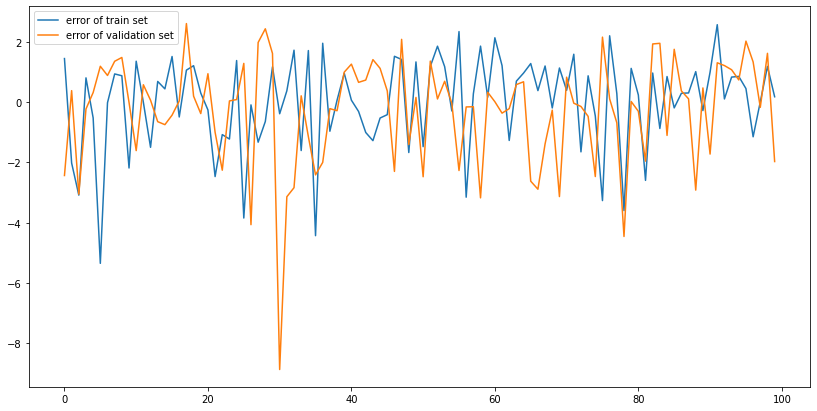

In [12]:
error = pd.DataFrame()
error['error of train set'] = e_train
error['error of validation set'] = e_validation
error.plot(figsize=(14,7))

### Prescriptive Analytics:

Use deterministic linear programming to solve the allocation model.

In [9]:
# get L1,L2,U1,U2
L1 = train_set[['TV','Radio']].min()[0]
L2 = train_set[['TV','Radio']].min()[1]
U1 = train_set[['TV','Radio']].max()[0]
U2 = train_set[['TV','Radio']].max()[1]
print(L1, U1, L2, U2)

5.4 293.6 1.4 49.6


julia code：

```julia
using JuMP
using Clp

beta0 = 3.1470
beta1 = 0.0459
beta2 = 0.1841

# Build model
model = Model(Clp.Optimizer)

@variables(model, begin
# Stage 1 Variables
    0.7<=x1<=296.4
    0<=x2<=49.6
# Stage 2 Variables
    yA>=0
    yB>=0
end)

# constraint
@constraint(model, b, x1+x2 <= 200)
@constraint(model, c, x1-0.5*x2 >= 0)
@constraint(model, d, yA <= 8)
@constraint(model, e, 2*yB <= 24)
@constraint(model, f, 3*yA+2*yB <= 36)
@constraint(model, g, -beta1*x1-beta2*x2+yA+yB <= beta0)

@objective(model, Max, -0.1*x1-0.5*x2+3*yA+5*yB)

# Optimization
optimize!(model)

# Assert problem is solved
# @assert(termination_status(model) == OPTIMAL)

@show value.(x1)
@show value.(x2)
@show objective_value(model)
```

    value.(x1) = 173.4225759768452
    value.(x2) = 26.577424023154833
    objective_value(model) = 41.36903039073806
    41.36903039073806
    Coin0506I Presolve 4 (-2) rows, 4 (0) columns and 10 (-2) elements
    Clp0006I 0  Obj -1.24 Dual inf 1.653402 (2)
    Clp0006I 3  Obj 41.36903
    Clp0000I Optimal - objective value 41.36903
    Coin0511I After Postsolve, objective 41.36903, infeasibilities - dual 0 (0), primal 0 (0)
    Clp0032I Optimal objective 41.36903039 - 3 iterations time 0.002, Presolve 0.00


### Validation

1. Do F-test of εti and εvi to check whether they are drawn from the same distribution. Alternatively, plot the histogram of εti and εvi .

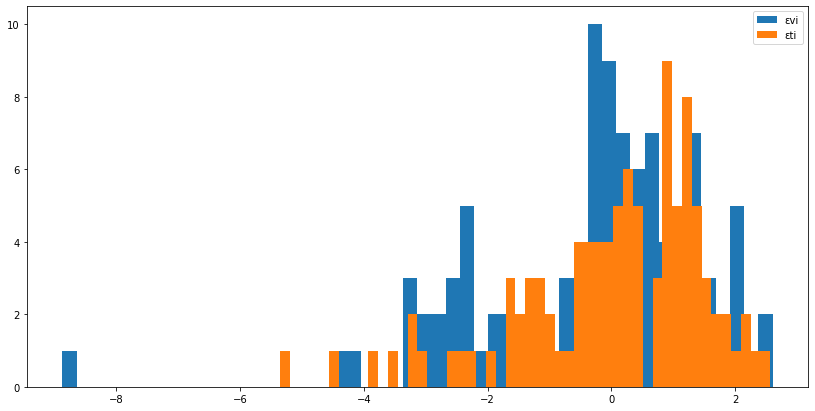

In [23]:
# plot histogram
fig = plt.figure(figsize=(14,7))

ax = fig.add_subplot(111)

ax.hist(e_validation, bins=50, label='εvi')
ax.hist(e_train, bins=50, label='εti')
plt.legend(loc='best')

plt.show()

2. Plot the Q-Q graph of εti and εvi to check whether they are normally distributed.

In [32]:
# F-test
F = np.var(e_train,ddof=1)/np.var(e_validation,ddof=1)
p_value = 1-stats.f.cdf(F, e_train.shape[0]-1, e_validation.shape[0]-1)
print(F, p_value)

0.7467511687023026 0.9259923671364864


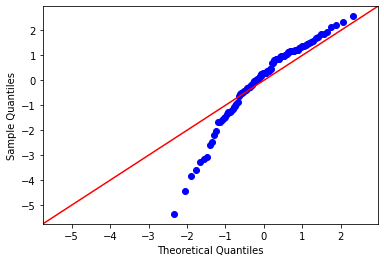

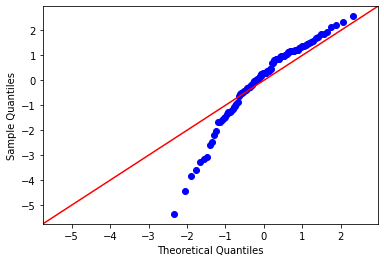

In [47]:
sm.qqplot(e_train, line ='45')

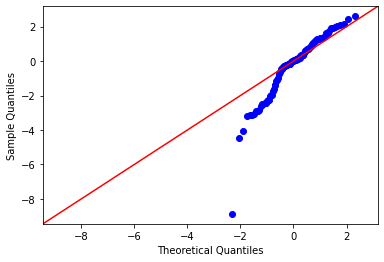

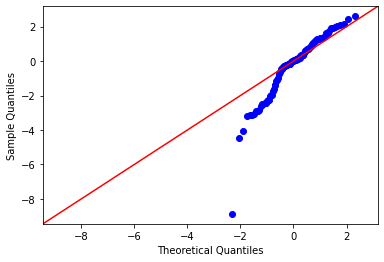

In [48]:
sm.qqplot(e_validation, line ='45')

3.  Using the εvi from Descriptive Analytics, calculate ωi as in (6).

In [8]:
beta0 = 3.1470
beta1 = 0.0459
beta2 = 0.1841
x1 = 173.4225759768452
x2 = 26.577424023154833
w_validation = beta0 + beta1*x1 + beta2*x2 + e_validation

Calculate Profit(ωi) in each scenario with $\hat{x_1}$, $\hat{x_2}$ fixed by solving second stage LPs

In [48]:
def maxProfit(w:float):
    """
    the second stage LP

    Parameters
    ----------
    w:float

    """
    # 

    yA = pulp.LpVariable("yA", cat='Continuous')
    yB = pulp.LpVariable("yB", cat='Continuous')

    model = pulp.LpProblem('Pmaxrofit', pulp.LpMaximize)
    
    # constraints
    model += (yA >= 0)
    model += (yB >= 0)
    model += (yA <= 8)
    model += (2*yB <= 24)
    model += (3*yA + 2*yB <= 36)
    model += (yA + yB <= w)
    # objective
    model += (3*yA+5*yB, "objective")

    # solver
    model.solve()
    pulp.LpStatus[model.status]

    # return x1, x2, obj
    profit = pulp.value(model.objective)

    return profit

Calculate the Model Validation Sample Average Estimate (MVSAE) and a confidence interval of the profit.

In [11]:
max_profit = list(map(lambda x:maxProfit(x), w_validation))
MVSAE = -0.1*x1-0.5*x2+np.mean(max_profit)

profit = np.array(max_profit) - 0.1*x1 - 0.5*x2
CI_lower = np.mean(profit) - 1.96*np.std(profit)/np.sqrt(len(profit))
CI_upper = np.mean(profit) + 1.96*np.std(profit)/np.sqrt(len(profit))
print('MVSAE:', MVSAE)
print('CI:',(CI_lower, CI_upper))
stats.t.interval(0.95, len(profit)-1, loc=np.mean(profit), scale=stats.sem(profit))

MVSAE: 38.886578573338056
CI: (37.94589595503824, 39.827261191637874)


(37.92947573043847, 39.843681416237644)

## 7.1.2 SAA

### Descriptive Analytics:

In [13]:
# first 100 data points for training and remaining 100 data points for validation
train_set = data.iloc[:100,:]
validation_set = data.iloc[100:,:]

X_train = train_set[['TV','Radio']].values
y_train = train_set['Sales'].values

X_train = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train).fit()

model.summary()

#validation set
X_test = validation_set[['TV','Radio']].values
X_test = sm.add_constant(X_test)
e_validation = validation_set['Sales'].values-model.predict(X_test)
#training set
e_train = train_set['Sales'].values-model.predict(X_train)

### Prescriptive Analytics:

In [52]:
# SAA
def SAA(e_t, beta0, beta1, beta2, L1, U1, L2, U2, N):
  """
  The all-in-one LP

  Parameters
  ----------
  e_t:list or np.array
  beta0, beta1, beta2, L1, U1, L2, U2: float
  N: int

  Returns
  ----------
  obj,x1, x2 :float
  """
  # variables
  x1 = pulp.LpVariable("x1", cat='Continuous')
  x2 = pulp.LpVariable("x2", cat='Continuous')
  yA = pulp.LpVariable.dicts("yA", ((i)for i in range(N)), cat='Continuous')
  yB = pulp.LpVariable.dicts("yB", ((i)for i in range(N)), cat='Continuous')

  model = pulp.LpProblem('profit', pulp.LpMaximize)
  obj_list = [-0.1*x1 - 0.5*x2]
  for i in range(N):
    obj_list.append((3*yA[i] + 5*yB[i])/N)
  model += (pulp.lpSum(obj_list), "objective")

  # constraints
  model += (x1 >= L1)
  model += (x1 <= U1)
  model += (x2 >= L2)
  model += (x2 <= U2)
  model += (x1 + x2 <= 200)
  model += (x1 - 0.5*x2 >= 0)
  for i in range(N):
      model += (yA[i] <= 8)
      model += (2*yB[i] <= 24)
      model += (3*yA[i] + 2*yB[i] <= 36)
      model += (-beta1*x1 - beta2*x2 + yA[i] + yB[i] <= beta0 + e_t[i])
      model += (yA[i] >= 0)
      model += (yB[i] >= 0)

  # solver
  model.solve() 
  pulp.LpStatus[model.status]

  # return obj,x1, x2                                
  obj = pulp.value(model.objective)
  return obj, x1.varValue, x2.varValue

In [15]:
beta0 = 3.1470
beta1 = 0.0459
beta2 = 0.1841
obj, x1, x2 = SAA(e_train, beta0, beta1, beta2, 0.7, 296.4, 0, 49.6, len(e_train))
obj, x1, x2

(40.87863054980004, 184.89353, 15.106465)

### Validation

In [18]:
w_validation = beta0 + beta1*x1 + beta2*x2 + e_validation

max_profit = list(map(lambda x:maxProfit(x), w_validation))
MVSAE = -0.1*x1-0.5*x2+np.mean(max_profit)

profit = np.array(max_profit) - 0.1*x1 - 0.5*x2
CI_lower = np.mean(profit) - 1.96*np.std(profit)/np.sqrt(len(profit))
CI_upper = np.mean(profit) + 1.96*np.std(profit)/np.sqrt(len(profit))
print('MVSAE:', MVSAE)
print('CI:',(CI_lower, CI_upper))

MVSAE: 39.86371668860001
CI: (38.64891473389625, 41.07851864330375)


## 7.1.3 SD

### Descriptive Analytics:

In [8]:
# first 100 data points for training and remaining 100 data points for validation
train_set = data.iloc[:100,:]
validation_set = data.iloc[100:,:]

X_train = train_set[['TV','Radio']].values
y_train = train_set['Sales'].values

X_train = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train).fit()

model.summary()

#validation set
X_test = validation_set[['TV','Radio']].values
X_test = sm.add_constant(X_test)
e_validation = validation_set['Sales'].values-model.predict(X_test)
#training set
e_train = train_set['Sales'].values-model.predict(X_train)

In [7]:
julia_data = pd.DataFrame(e_train)
julia_data.to_csv('e_train.csv')

### Prescriptive Analytics:

```julia

using CPLEX
using TwoSD

e_train_data = CSV.read("e_train.csv", DataFrame)
e_train = e_train_data[:,2]

model = direct_model(CPLEX.Optimizer())

@variables(model, begin
# Stage 1 Variables
    0.7<=x1<=296.4
    0<=x2<=49.6
# Stage 2 Variables
    yA>=0
    yB>=0
end)

# constraint
@constraint(model, b, x1+x2 <= 200)
@constraint(model, c, x1-0.5*x2 >= 0)
@constraint(model, d, yA <= 8)
@constraint(model, e, 2*yB <= 24)
@constraint(model, f, 3*yA+2*yB <= 36)
@constraint(model, g, -beta1*x1-beta2*x2+yA+yB <= 0) #beta0

@objective(model, Min, 0.1*x1+0.5*x2-3*yA-5*yB)

split_position = Position(d, yA)
r = Random.MersenneTwister(888)
function mystoc()
    e = rand(r, e_train)
    binding = [Position(g, "RHS") => e+beta0]
    return OneRealization(binding)
end

user_mean = [beta0]

solve_sd(model, split_position, user_mean, mystoc)

```

### Validation

In [9]:
x1 = 185.1
x2 = 14.5

beta0 = 3.1470
beta1 = 0.0459
beta2 = 0.1841

In [12]:
w_validation = beta0 + beta1*x1 + beta2*x2 + e_validation

max_profit = list(map(lambda x:maxProfit(x), w_validation))
MVSAE = -0.1*x1-0.5*x2+np.mean(max_profit)

profit = np.array(max_profit) - 0.1*x1 - 0.5*x2
CI_lower = np.mean(profit) - 1.96*np.std(profit)/np.sqrt(len(profit))
CI_upper = np.mean(profit) + 1.96*np.std(profit)/np.sqrt(len(profit))
print('MVSAE:', MVSAE)
print('CI:',(CI_lower, CI_upper))

MVSAE: 39.838388864609996
CI: (38.60732796305289, 41.06944976616709)


## Outliers Analytics

In [14]:
X = data[['TV','Radio']].values
X = sm.add_constant(X)

model = sm.OLS(y_train, X_train).fit()

e = data['Sales'].values-model.predict(X)

In [38]:
# method1

upper =np.mean(e) + 1.5* np.std(e)
lower = np.mean(e) - 1.5* np.std(e)
indices = [idx for idx, val in enumerate(e) if val <= upper and val >= lower]

In [42]:
# method2

Q1 = np.percentile(e, 25, interpolation = 'midpoint')
Q3 = np.percentile(e, 75, interpolation = 'midpoint')
upper = Q3 + 1.5*(Q3 - Q1)
lower = Q3 - 1.5*(Q3 - Q1)
indices = [idx for idx, val in enumerate(e) if val <= upper and val >= lower]

In [43]:
data_after_out = data.iloc[indices,:].copy()
data_after_out.index = np.arange(len(data_after_out))

# first 100 data points for training and remaining 100 data points for validation
train_set = data_after_out.iloc[:int(len(data_after_out)/2),:]
validation_set = data_after_out.iloc[int(len(data_after_out)/2):,:]

X_train = train_set[['TV','Radio']].values
y_train = train_set['Sales'].values

X_train = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train).fit()

model.summary()

#validation set
X_test = validation_set[['TV','Radio']].values
X_test = sm.add_constant(X_test)
e_validation = validation_set['Sales'].values-model.predict(X_test)
#training set
e_train = train_set['Sales'].values-model.predict(X_train)

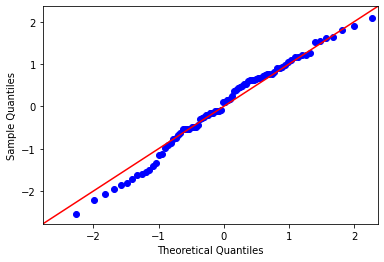

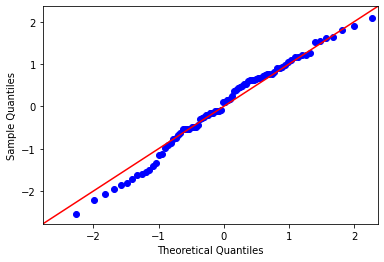

In [46]:
sm.qqplot(e_train, line ='45')

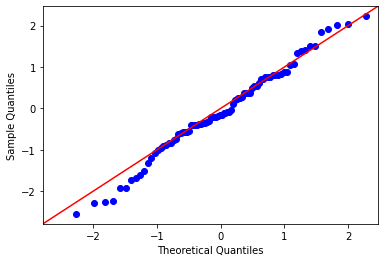

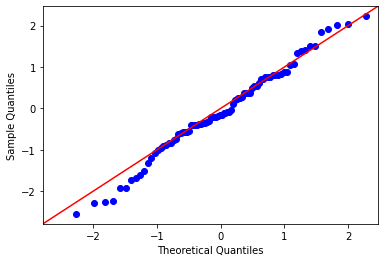

In [45]:
sm.qqplot(e_validation, line ='45')

In [47]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     901.1
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           5.19e-57
Time:                        21:39:18   Log-Likelihood:                -126.19
No. Observations:                  86   AIC:                             258.4
Df Residuals:                      83   BIC:                             265.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8532      0.285     13.498      0.000       3.285       4.421
x1             0.0442      0.002     28.255      0.000       0.041       0.047
x2             0.1812      0.009     20.266      0.000       0.163       0.199
==============================================================================
Omnibus:                        2.799   Durbin-Watson:                   2.300
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                2.497
Skew:                          -0.322   Prob(JB):                        0.287
Kurtosis:                       2.468   Cond. No.                         417.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
beta0 = 3.8532
beta1 = 0.0442
beta2 = 0.1812
x1 = 175.86277372262774
x2 = 24.13722627737225
w_validation = beta0 + beta1*x1 + beta2*x2 + e_validation

In [50]:
def maxProfit(w:float):
    """
    the second stage LP

    Parameters
    ----------
    w:float

    """
    # 

    yA = pulp.LpVariable("yA", cat='Continuous')
    yB = pulp.LpVariable("yB", cat='Continuous')

    model = pulp.LpProblem('Pmaxrofit', pulp.LpMaximize)
    
    # constraints
    model += (yA >= 0)
    model += (yB >= 0)
    model += (yA <= 8)
    model += (2*yB <= 24)
    model += (3*yA + 2*yB <= 36)
    model += (yA + yB <= w)
    # objective
    model += (3*yA+5*yB, "objective")

    # solver
    model.solve()
    pulp.LpStatus[model.status]

    # return x1, x2, obj
    profit = pulp.value(model.objective)

    return profit

In [51]:
max_profit = list(map(lambda x:maxProfit(x), w_validation))
MVSAE = -0.1*x1-0.5*x2+np.mean(max_profit)

profit = np.array(max_profit) - 0.1*x1 - 0.5*x2
CI_lower = np.mean(profit) - 1.96*np.std(profit)/np.sqrt(len(profit))
CI_upper = np.mean(profit) + 1.96*np.std(profit)/np.sqrt(len(profit))
print('MVSAE:', MVSAE)
print('CI:',(CI_lower, CI_upper))
stats.t.interval(0.95, len(profit)-1, loc=np.mean(profit), scale=stats.sem(profit))

MVSAE: 40.971296326260386
CI: (40.55870075015148, 41.383891902369335)


(40.55029529357366, 41.392297358947154)

In [53]:
beta0 = 3.8532
beta1 = 0.0442
beta2 = 0.1812
obj, x1, x2 = SAA(e_train, beta0, beta1, beta2, 0.7, 296.4, 0, 49.6, len(e_train))
obj, x1, x2

(42.17796520197672, 188.86186, 11.138143)

In [54]:
max_profit = list(map(lambda x:maxProfit(x), w_validation))
MVSAE = -0.1*x1-0.5*x2+np.mean(max_profit)

profit = np.array(max_profit) - 0.1*x1 - 0.5*x2
CI_lower = np.mean(profit) - 1.96*np.std(profit)/np.sqrt(len(profit))
CI_upper = np.mean(profit) + 1.96*np.std(profit)/np.sqrt(len(profit))
print('MVSAE:', MVSAE)
print('CI:',(CI_lower, CI_upper))
stats.t.interval(0.95, len(profit)-1, loc=np.mean(profit), scale=stats.sem(profit))

MVSAE: 46.17092933720929
CI: (45.758333761100374, 46.58352491331823)


(45.749928304522555, 46.59193036989605)

## SVR

In [55]:
from sklearn import  svm

In [56]:
clf = svm.SVR(kernel='linear')

In [72]:
data_after_out = data.iloc[indices,:].copy()
data_after_out.index = np.arange(len(data_after_out))

# first 100 data points for training and remaining 100 data points for validation
train_set = data_after_out.iloc[:int(len(data_after_out)/2),:]
validation_set = data_after_out.iloc[int(len(data_after_out)/2):,:]

X_train = train_set[['TV','Radio']].values
y_train = train_set['Sales'].values


model = clf.fit(X_train, y_train)


print(model.coef_)
beta0 = np.mean(y_train) - model.coef_[0][0]*np.mean(train_set['TV'].values)-model.coef_[0][1]*np.mean(train_set['Radio'].values)
print(beta0)
#validation set
X_test = validation_set[['TV','Radio']].values
e_validation = validation_set['Sales'].values-model.predict(X_test)
#training set
e_train = train_set['Sales'].values-model.predict(X_train)

[[0.04125646 0.17162406]]
4.528051767181878


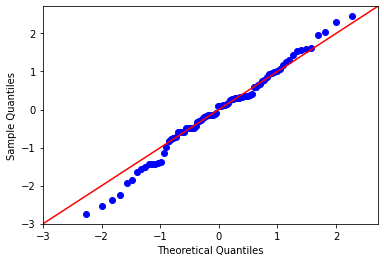

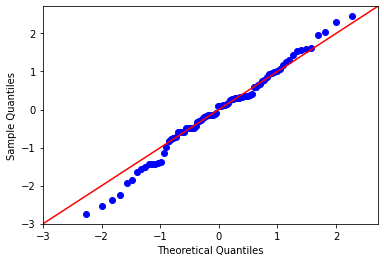

In [69]:
sm.qqplot(e_train, line ='45')

In [67]:
beta0 = 4.528051767181878
beta1 = 0.04125646 
beta2 = 0.17162406
x1 = 199.99999999999997
x2 = 0
w_validation = beta0 + beta1*x1 + beta2*x2 + e_validation
max_profit = list(map(lambda x:maxProfit(x), w_validation))
MVSAE = -0.1*x1-0.5*x2+np.mean(max_profit)

profit = np.array(max_profit) - 0.1*x1 - 0.5*x2
CI_lower = np.mean(profit) - 1.96*np.std(profit)/np.sqrt(len(profit))
CI_upper = np.mean(profit) + 1.96*np.std(profit)/np.sqrt(len(profit))
print('MVSAE:', MVSAE)
print('CI:',(CI_lower, CI_upper))
stats.t.interval(0.95, len(profit)-1, loc=np.mean(profit), scale=stats.sem(profit))

MVSAE: 41.53858468313954
CI: (40.66852765298347, 42.40864171329561)


(40.650802725692266, 42.426366640586814)

In [65]:
beta0 = 4.528051767181878
beta1 = 0.04125646 
beta2 = 0.17162406
obj, x1, x2 = SAA(e_train, beta0, beta1, beta2, 0.7, 296.4, 0, 49.6, len(e_train))
obj, x1, x2

(42.082706004999984, 191.79776, 8.2022399)

In [66]:
max_profit = list(map(lambda x:maxProfit(x), w_validation))
MVSAE = -0.1*x1-0.5*x2+np.mean(max_profit)

profit = np.array(max_profit) - 0.1*x1 - 0.5*x2
CI_lower = np.mean(profit) - 1.96*np.std(profit)/np.sqrt(len(profit))
CI_upper = np.mean(profit) + 1.96*np.std(profit)/np.sqrt(len(profit))
print('MVSAE:', MVSAE)
print('CI:',(CI_lower, CI_upper))
stats.t.interval(0.95, len(profit)-1, loc=np.mean(profit), scale=stats.sem(profit))

MVSAE: 47.34529088720929
CI: (46.932695311100375, 47.75788646331823)


(46.924289854522556, 47.76629191989605)